In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm
from scipy.spatial.transform import Rotation as R
import sympy as sp
from sympy.physics.quantum.spin import Rotation as WignerRotation

# --- Step 1: Simulate vector trajectory on a cone ---
def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000):
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)
    phi = 0.0
    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vectors[i] = np.array([x, y, z])
    return vectors

# --- Step 2: Compute spherical harmonic time series ---
def compute_Ylm_series(vectors, l=2):
    theta = np.arccos(vectors[:, 2])
    phi = np.arctan2(vectors[:, 1], vectors[:, 0])
    Y_series = {}
    for m in range(-l, l + 1):
        Y_series[m] = sph_harm(m, l, phi, theta)
    return Y_series

# --- Step 3: Compute C_{l,m,m'}(t) matrix ---
def compute_correlation_matrix(Y_series, max_lag=1000):
    l = max(Y_series.keys())
    corr_matrix = {}
    for m1 in range(-l, l + 1):
        for m2 in range(-l, l + 1):
            corr = []
            y1 = Y_series[m1]
            y2 = Y_series[m2]
            for tau in range(max_lag):
                val = np.mean(y1[:-tau or None] * np.conj(y2[tau:])) if tau > 0 else np.mean(y1 * np.conj(y2))
                corr.append(val)
            corr_matrix[(m1, m2)] = np.array(corr)
    return corr_matrix

# --- Step 4: Construct Wigner D-matrix ---
#from scipy.special import wignerd

def wigner_D_l2(alpha, beta, gamma):
    c = np.cos(beta / 2)
    s = np.sin(beta / 2)

    d = np.array([
        [c**4, 2*c**3*s, np.sqrt(6)*c**2*s**2, 2*c*s**3, s**4],
        [-2*c**3*s, c**2*(c**2 - 3*s**2), -np.sqrt(6)*c*s*(c**2 - s**2), s**2*(3*c**2 - s**2), -2*c*s**3],
        [np.sqrt(6)*c**2*s**2, np.sqrt(6)*c*s*(c**2 - s**2), 1.5*(c**4 - s**4), -np.sqrt(6)*s*c*(c**2 - s**2), np.sqrt(6)*s**2*c**2],
        [-2*s**3*c, s**2*(3*c**2 - s**2), np.sqrt(6)*s*c*(c**2 - s**2), c**2*(c**2 - 3*s**2), 2*s*c**3],
        [s**4, -2*s**3*c, np.sqrt(6)*s**2*c**2, -2*s*c**3, c**4]
    ])

    m_vals = np.arange(-2, 3)
    D = np.zeros((5, 5), dtype=complex)
    for i, m in enumerate(m_vals):
        for j, mp in enumerate(m_vals):
            D[i, j] = np.exp(-1j * m * alpha) * d[i, j] * np.exp(-1j * mp * gamma)
    return D



# --- Step 5: Rotate correlation matrix ---
def rotate_correlation_matrix(corr_matrix, l, D):
    corr_rotated = {}
    m_vals = range(-l, l + 1)
    for i, m in enumerate(m_vals):
        corr_rotated[m] = np.zeros_like(next(iter(corr_matrix.values())), dtype=complex)
        for j, m1 in enumerate(m_vals):
            for k, m2 in enumerate(m_vals):
                corr_rotated[m] += D[i, j] * corr_matrix[(m1, m2)] * np.conj(D[i, k])
    return corr_rotated



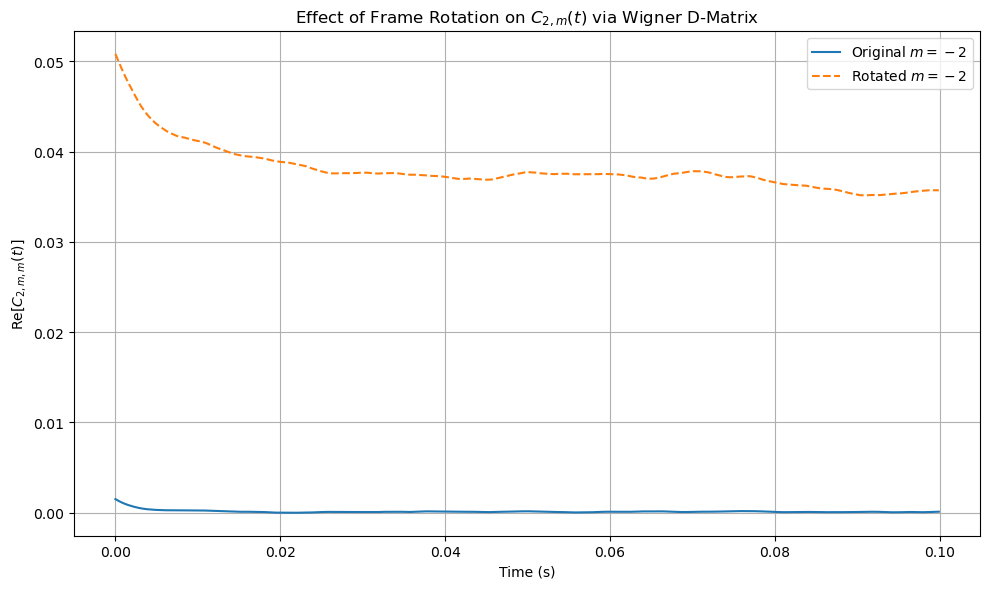

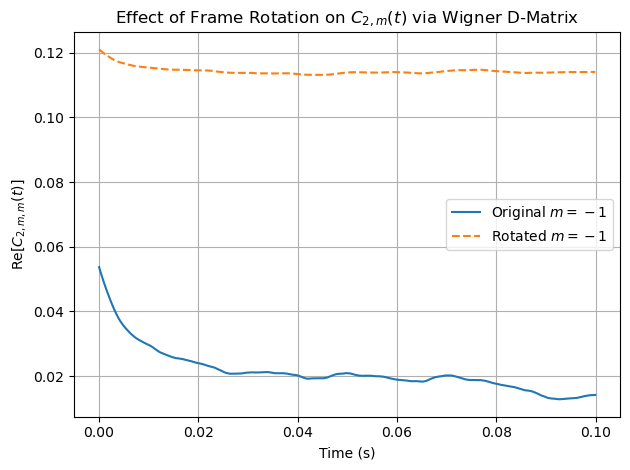

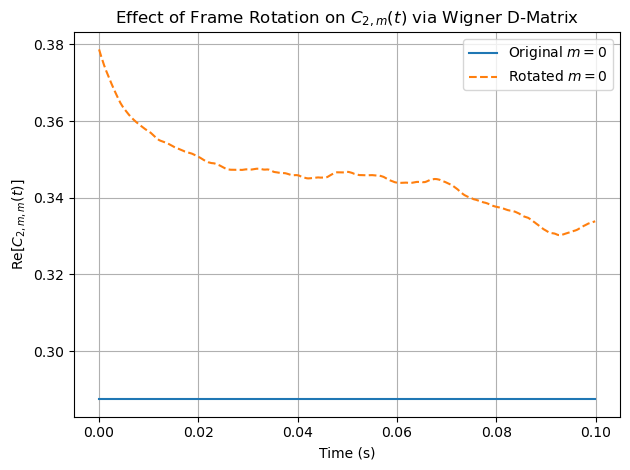

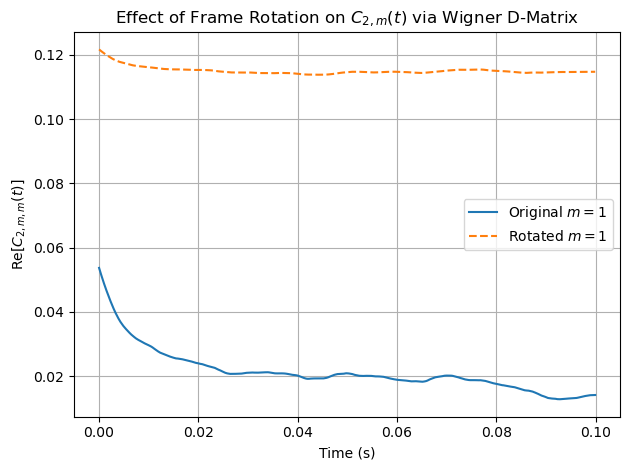

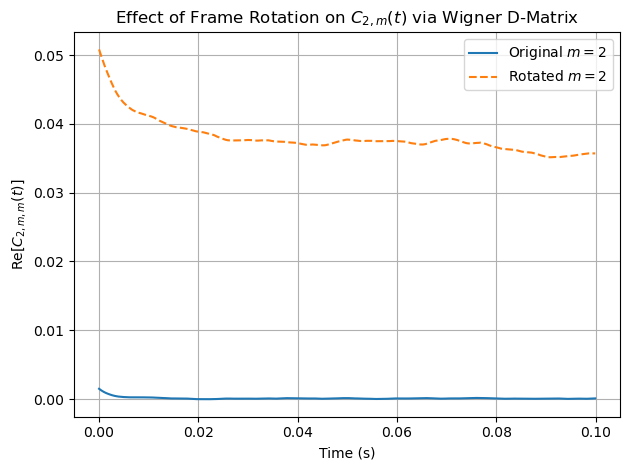

In [8]:
l = 2
dt = 1e-4
vectors = simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=dt)
Y_series = compute_Ylm_series(vectors, l=l)
corr_matrix = compute_correlation_matrix(Y_series)

# Get Euler angles from rotation (e.g., 45 degrees around x-axis)
rot = R.from_euler('x', 45, degrees=True)
alpha, beta, gamma = rot.as_euler('zyz')  # Convert to zyz Euler angles
D = wigner_D_l2(alpha, beta, gamma)
corr_rotated = rotate_correlation_matrix(corr_matrix, l, D)

# Plot comparison of original vs rotated C_{2,m}(t)
t = np.arange(len(next(iter(corr_matrix.values())))) * dt
plt.figure(figsize=(10, 6))
for m in [-2, -1, 0, 1, 2]:
    plt.plot(t, np.real(corr_matrix[(m, m)]), label=fr'Original $m={m}$', linestyle='-')
    plt.plot(t, np.real(corr_rotated[m]), label=fr'Rotated $m={m}$', linestyle='--')
    plt.xlabel("Time (s)")
    plt.ylabel(r"$\mathrm{Re}[C_{2,m,m}(t)]$")
    plt.title("Effect of Frame Rotation on $C_{2,m}(t)$ via Wigner D-Matrix")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
